In [65]:
import torch
import matplotlib

prefix = "../../experiments_02_09_2025/picnn_fnlvqr_star"
quantile_metric_name_to_model_name_to_metric_mean = {
    "wasserstein2":{},
    "sliced_wasserstein2":{},
    "unexplained_variance_percentage":{},
    "kde_kl_divergence":{},
    "kde_l1_divergence":{},
}
rank_metric_name_to_model_name_to_metric_mean = {
    "wasserstein2":{},
    "sliced_wasserstein2":{},
    "unexplained_variance_percentage":{},
    "kde_kl_divergence":{},
    "kde_l1_divergence":{},
}
quantile_metric_name_to_model_name_to_metric_std = {
    "wasserstein2":{},
    "sliced_wasserstein2":{},
    "unexplained_variance_percentage":{},
    "kde_kl_divergence":{},
    "kde_l1_divergence":{},
}
rank_metric_name_to_model_name_to_metric_std = {
    "wasserstein2":{},
    "sliced_wasserstein2":{},
    "unexplained_variance_percentage":{},
    "unexplained_variance_percentage":{},
    "kde_kl_divergence":{},
    "kde_l1_divergence":{},
}

(
    model_name_to_idx,
    idx_to_model_name,
    model_name_to_color
) = {}, {}, {}

model_name_to_metric_path = {
    "EntropicNeuralQuantileRegression":"entropic_neural_quantile_regression/metrics.pth",
    "NeuralQuantileRegressionU":"neural_quantile_regression_u/metrics.pth",
    "NeuralQuantileRegressionY":"neural_quantile_regression_y/metrics.pth",
    "AmortizedNeuralQuantileRegressionU":"amortized_neural_quantile_regression_u/metrics.pth",
    "AmortizedNeuralQuantileRegressionY":"amortized_neural_quantile_regression_y/metrics.pth",
    "ConvexPotentialFlow":"convex_potential_flow/metrics.pth",
}

for idx, (model_name, path_to_metric) in enumerate(model_name_to_metric_path.items()):
    model_name_to_idx[model_name] = idx
    idx_to_model_name[idx] = model_name
    model_name_to_color = matplotlib.colormaps['hsv'](idx / len(model_name_to_metric_path))
    metrics_dict = torch.load(f"{prefix}/{path_to_metric}", torch.device("cpu"), weights_only=False)
    
    for key in metrics_dict['quantile'].keys():
        metric = torch.stack(metrics_dict['quantile'][key])
        quantile_metric_name_to_model_name_to_metric_mean[key][model_name] = metric.mean().item()
        quantile_metric_name_to_model_name_to_metric_std[key][model_name] = metric.std().item()

    for key in metrics_dict['inverse_quantile'].keys():
        metric = torch.stack(metrics_dict['inverse_quantile'][key])
        rank_metric_name_to_model_name_to_metric_mean[key][model_name] = metric.mean().item()
        rank_metric_name_to_model_name_to_metric_std[key][model_name] = metric.std().item()

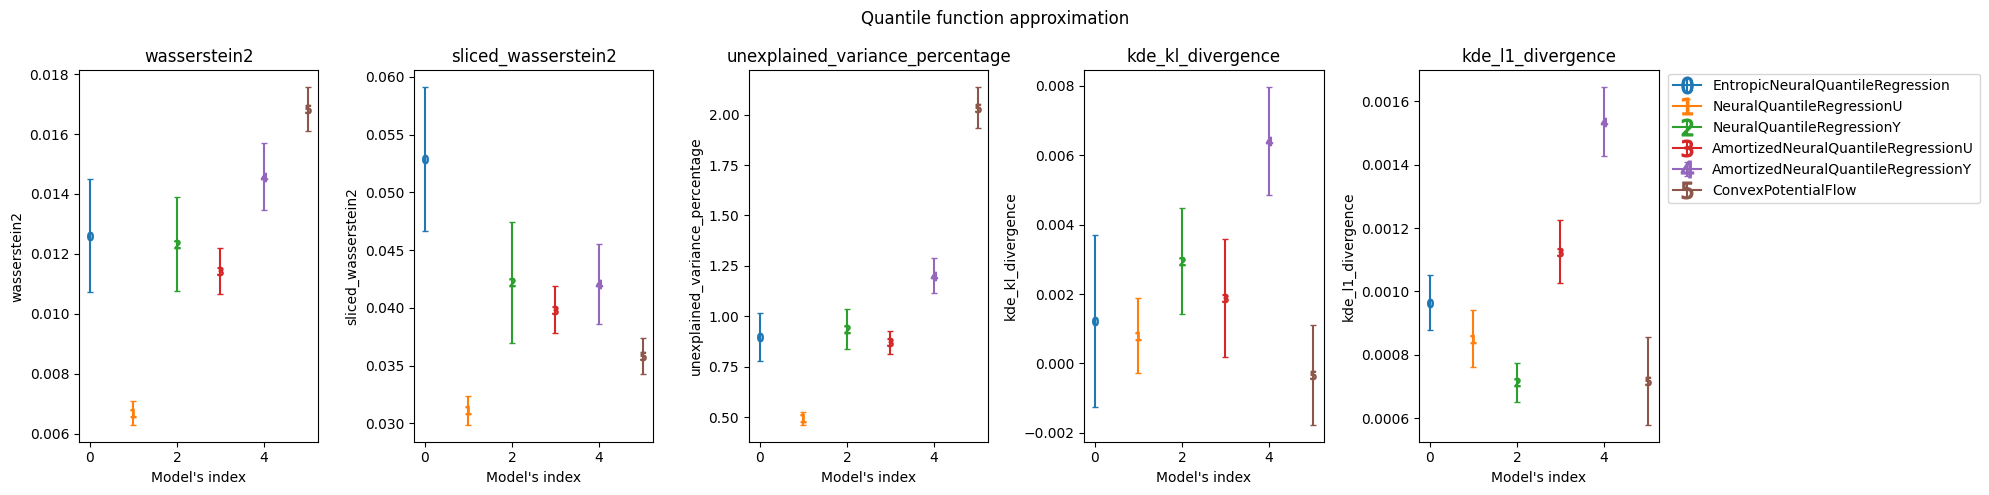

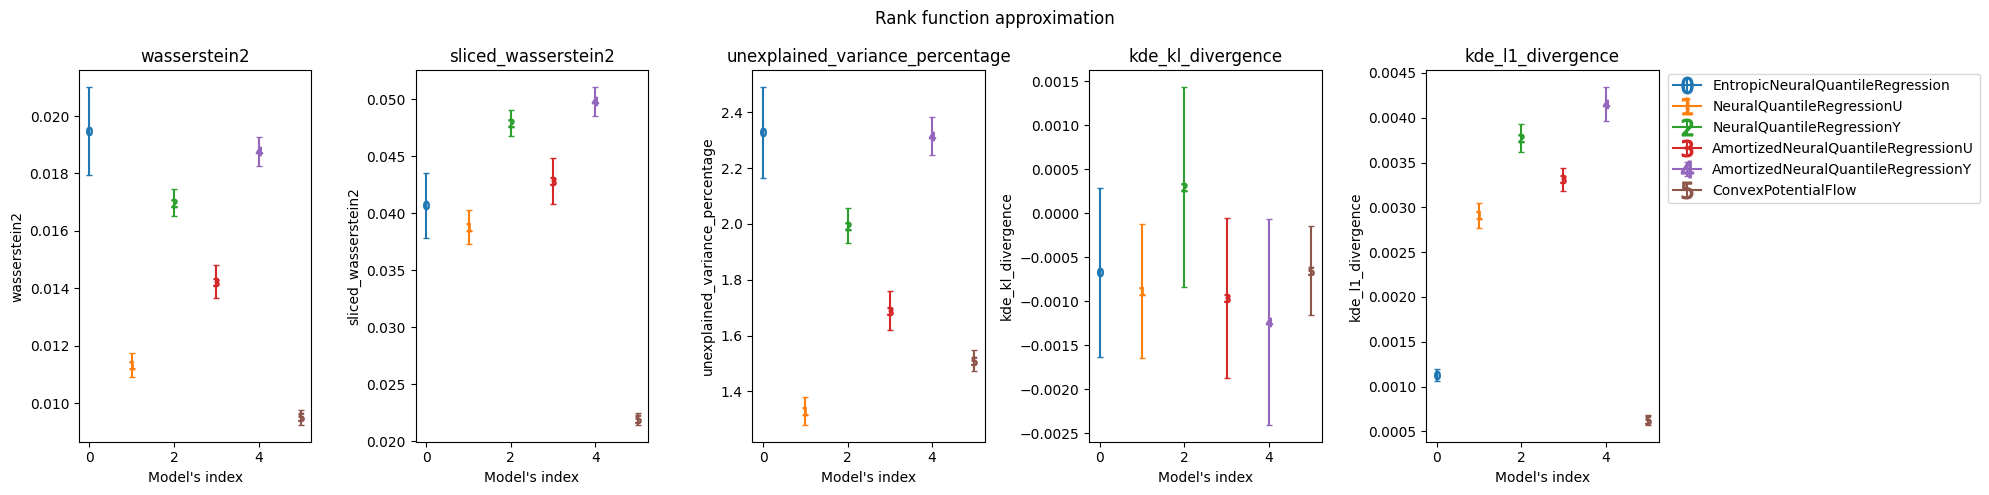

In [66]:
import matplotlib.pyplot as plt

number_of_metrics = len(quantile_metric_name_to_model_name_to_metric_mean)
fig, axs = plt.subplots(1, number_of_metrics, figsize=(20, 5))
metric_name_to_ax = {metric_name: ax for metric_name, ax in zip(quantile_metric_name_to_model_name_to_metric_mean.keys(), axs)}

fig.suptitle("Quantile function approximation")

for metric_name, ax in metric_name_to_ax.items():
    ax.set_title(metric_name)
    ax.set_xlabel("Model's index")
    ax.set_ylabel(metric_name)

for metric_name, ax in metric_name_to_ax.items():
    for model_name, metric_mean in quantile_metric_name_to_model_name_to_metric_mean[metric_name].items():
        metric_std = quantile_metric_name_to_model_name_to_metric_std[metric_name][model_name]
        ax.errorbar(
            model_name_to_idx[model_name], metric_mean,
            yerr=metric_std / 2,
            marker=f'${model_name_to_idx[model_name]}$',
            label=model_name,
            capsize=2
        )

axs[-1].legend(markerscale=2, bbox_to_anchor=[1.01, 1.01], loc='upper left')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, number_of_metrics, figsize=(20, 5))
metric_name_to_ax = {metric_name: ax for metric_name, ax in zip(rank_metric_name_to_model_name_to_metric_mean.keys(), axs)}

fig.suptitle("Rank function approximation")

for metric_name, ax in metric_name_to_ax.items():
    ax.set_title(metric_name)
    ax.set_xlabel("Model's index")
    ax.set_ylabel(metric_name)

for metric_name, ax in metric_name_to_ax.items():
    for model_name, metric_mean in rank_metric_name_to_model_name_to_metric_mean[metric_name].items():
        metric_std = rank_metric_name_to_model_name_to_metric_std[metric_name][model_name]
        ax.errorbar(
            model_name_to_idx[model_name], metric_mean,
            yerr=metric_std / 2,
            marker=f'${model_name_to_idx[model_name]}$',
            label=model_name,
            capsize=2
        )

axs[-1].legend(markerscale=2, bbox_to_anchor=[1.01, 1.01], loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
def print_metrics_table(metric_name_to_model_mean, metric_name_to_model_std, title):
    metric_names = list(metric_name_to_model_mean.keys())
    model_names = list(next(iter(metric_name_to_model_mean.values())).keys())

    rows = []
    header = ["Model"] + metric_names
    rows.append(header)

    for model_name in model_names:
        row = [model_name]
        for metric_name in metric_names:
            mean = abs(metric_name_to_model_mean[metric_name][model_name])
            std = metric_name_to_model_std[metric_name][model_name] / 2
            row.append(f"{mean:.4f} ± {std:.4f}")
        rows.append(row)

    col_widths = [max(len(row[i]) for row in rows) for i in range(len(rows[0]))]

    def fmt_cell(text, width):
        return str(text).ljust(width)

    print(f"\n~{title}~")

    header_row = " | ".join(fmt_cell(cell, w) for cell, w in zip(rows[0], col_widths))
    print(header_row)
    print("-" * len(header_row))

    for row in rows[1:]:
        print(" | ".join(fmt_cell(cell, w) for cell, w in zip(row, col_widths)))


print_metrics_table(
    quantile_metric_name_to_model_name_to_metric_mean,
    quantile_metric_name_to_model_name_to_metric_std,
    "Quantile function approximation"
)

print_metrics_table(
    rank_metric_name_to_model_name_to_metric_mean,
    rank_metric_name_to_model_name_to_metric_std,
    "Rank function approximation"
)



~Quantile function approximation~
Model                              | wasserstein2    | sliced_wasserstein2 | unexplained_variance_percentage | kde_kl_divergence | kde_l1_divergence
----------------------------------------------------------------------------------------------------------------------------------------------------
EntropicNeuralQuantileRegression   | 0.0126 ± 0.0019 | 0.0529 ± 0.0062     | 0.8973 ± 0.1182                 | 0.0012 ± 0.0025   | 0.0010 ± 0.0001  
NeuralQuantileRegressionU          | 0.0067 ± 0.0004 | 0.0311 ± 0.0013     | 0.4961 ± 0.0329                 | 0.0008 ± 0.0011   | 0.0009 ± 0.0001  
NeuralQuantileRegressionY          | 0.0123 ± 0.0016 | 0.0422 ± 0.0052     | 0.9387 ± 0.0978                 | 0.0030 ± 0.0015   | 0.0007 ± 0.0001  
AmortizedNeuralQuantileRegressionU | 0.0114 ± 0.0008 | 0.0398 ± 0.0020     | 0.8722 ± 0.0575                 | 0.0019 ± 0.0017   | 0.0011 ± 0.0001  
AmortizedNeuralQuantileRegressionY | 0.0146 ± 0.0011 | 0.0421 ± 0.0035 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top5_models(metric_prefix: str, title: str):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)

    axes = {
        "l2_distance": ax1,
        "wasserstein2": ax2,
        "hausdorff_distance": ax3,
    }

    # Titles & labels
    ax1.set_title("Average L2 distance")
    ax1.set_xlabel("Model's index")
    ax1.set_ylabel("Average L2 distance")

    ax2.set_title("Wasserstein-2")
    ax2.set_xlabel("Model's index")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Hausdorff Error")
    ax3.set_xlabel("Model's index")
    ax3.set_ylabel("Hausdorff Error")

    # Collect top 5 models across all metrics (union)
    top_models = set()
    for metric_suffix in axes:
        metric_name = f"{metric_prefix}_{metric_suffix}"
        means = metric_name_to_model_name_to_metric_mean[metric_name]
        sorted_models = sorted(means.items(), key=lambda x: x[1])[:5]
        top_models.update(m for m, _ in sorted_models)

    top_models = list(top_models)

    # Assign consistent colors/markers
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_models)))
    model_to_style = {m: colors[i] for i, m in enumerate(top_models)}

    handles = []

    for metric_suffix, ax in axes.items():
        metric_name = f"{metric_prefix}_{metric_suffix}"
        means = metric_name_to_model_name_to_metric_mean[metric_name]
        stds = metric_name_to_model_name_to_metric_std[metric_name]

        # Plot only top models for this metric
        for model_name in top_models:
            if model_name not in means:
                continue

            idx = model_name_to_idx[model_name]
            mean_val = means[model_name]
            std_val = stds[model_name]

            h = ax.errorbar(
                idx,
                mean_val,
                yerr=std_val,
                fmt="o",
                capsize=5,
                color=model_to_style[model_name],
                label=model_name,
            )
            # Collect one handle per model (for shared legend)
            if metric_suffix == "hausdorff_distance":
                handles.append(h)

    # Single shared legend next to last subplot
    ax3.legend(
        handles,
        [h.get_label() for h in handles],
        markerscale=2,
        bbox_to_anchor=(1.01, 1.01),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


# Plot both sets
plot_top5_models("quantile", "Quantile function approximation (Top-5)")
plot_top5_models("inverse_quantile", "Inverse quantile function approximation (Top-5)")

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Quantile function approximation")

ax1.set_title("Average L2 distance")
ax1.set_xlabel("Model's index")
ax1.set_ylabel("Average L2 distance")

ax2.set_title("Wasserstein-2")
ax2.set_xlabel("Model's index")
ax2.set_ylabel("Wasserstein-2")

ax3.set_title("Hausdorff Error")
ax3.set_xlabel("Model's index")
ax3.set_ylabel("Hausdorff Error")

for model_name, idx in model_name_to_idx.items():
    if model_name in metric_name_to_model_name_to_metric_mean["quantile_l2_distance"]:
        l2_distance = metric_name_to_model_name_to_metric_mean["quantile_l2_distance"][model_name]
        ax1.scatter(idx, l2_distance, marker=f'${idx}$', label=model_name)

    if model_name in metric_name_to_model_name_to_metric_mean["quantile_wasserstein2"]:
        wasserstein2 = metric_name_to_model_name_to_metric_mean["quantile_wasserstein2"][model_name]
        ax2.scatter(idx, wasserstein2, marker=f'${idx}$', label=model_name)

    
    if model_name in metric_name_to_model_name_to_metric_mean["quantile_hausdorff_distance"]:
        quantile_error = metric_name_to_model_name_to_metric_mean["quantile_hausdorff_distance"][model_name]
        ax3.scatter(idx, quantile_error, marker=f'${idx}$', label=model_name)


ax3.legend(markerscale=2, bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Inverse quantile function approximation")

ax1.set_title("Average L2 distance")
ax1.set_xlabel("Model's index")
ax1.set_ylabel("Average L2 distance")

ax2.set_title("Wasserstein-2")
ax2.set_xlabel("Model's index")
ax2.set_ylabel("Wasserstein-2")

ax3.set_title("Hausdorff Error")
ax3.set_xlabel("Model's index")
ax3.set_ylabel("Hausdorff Error")

for model_name, idx in model_name_to_idx.items():
    if model_name in metric_name_to_model_name_to_metric_mean["inverse_quantile_l2_distance"]:
        l2_distance = metric_name_to_model_name_to_metric_mean["inverse_quantile_l2_distance"][model_name]
        ax1.scatter(idx, l2_distance, marker=f'${idx}$', label=model_name)

    if model_name in metric_name_to_model_name_to_metric_mean["inverse_quantile_wasserstein2"]:
        wasserstein2 = metric_name_to_model_name_to_metric_mean["inverse_quantile_wasserstein2"][model_name]
        ax2.scatter(idx, wasserstein2, marker=f'${idx}$', label=model_name)

    
    if model_name in metric_name_to_model_name_to_metric_mean["inverse_quantile_hausdorff_distance"]:
        quantile_error = metric_name_to_model_name_to_metric_mean["inverse_quantile_hausdorff_distance"][model_name]
        ax3.scatter(idx, quantile_error, marker=f'${idx}$', label=model_name)


ax3.legend(markerscale=2, bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Performance Comparison for Top 5 Models", fontsize=16)

index_to_metric = {}

all_indices = []
all_wasserstein2, all_wasserstein2_stds = [], []
all_quantile_error, all_quantile_error_stds = [], []
all_l2_distance, all_l2_distance_stds = [], []

for model_name, idx in model_name_to_idx.items():
    l2_distance_mean = metric_name_to_model_name_to_metric_mean["l2_distance"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    l2_distance_std = metric_name_to_model_name_to_metric_std["l2_distance"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_wasserstein2.append(wasserstein2_mean)
    all_quantile_error.append(quantile_error_mean)
    all_l2_distance.append(l2_distance_mean)

    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)
    all_l2_distance_stds.append(l2_distance_std)

    all_indices.append(idx)

all_wasserstein2_tensor = torch.tensor(all_wasserstein2)
all_quantile_error_tensor = torch.tensor(all_quantile_error)
all_l2_distance_tensor = torch.tensor(all_l2_distance)

top_5_l2_distance_models = all_l2_distance_tensor.argsort()[:5]
top_5_wasserstein2_models = all_wasserstein2_tensor.argsort()[:5]
top_5_quantile_error_models = all_quantile_error_tensor.argsort()[:5]

def plot_barchart(axis, title, metric_name, top_indices, model_name_to_metric_mean, model_name_to_metric_std, lower_is_better=True):
    axis.set_title(title)

    model_names = [idx_to_model_name[i.item()] for i in top_indices]
    means = [model_name_to_metric_mean[model_name] for model_name in model_names]
    stds = [model_name_to_metric_std[model_name] for model_name in model_names]

    sorted_data = sorted(zip(means, stds, model_names), reverse=not lower_is_better)
    sorted_means, sorted_stds, sorted_names = zip(*sorted_data)

    y_pos = np.arange(len(sorted_names))
    colors = plt.cm.viridis(np.linspace(0, 1, len(y_pos)))

    axis.barh(y_pos, sorted_means, xerr=sorted_stds, align='center', color=colors, capsize=5)
    axis.set_yticks(y_pos)
    axis.set_yticklabels(sorted_names)
    axis.invert_yaxis()
    axis.set_xlabel(metric_name)
    axis.grid(True, which="major", axis='x', ls="--", c='0.8')

plot_barchart(
    axis=ax1,
    title="Mean L2 distance",
    metric_name="Mean L2 distance",
    top_indices=top_5_l2_distance_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["l2_distance"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["l2_distance"],
    lower_is_better=True
)

plot_barchart(
    axis=ax2,
    title="Wasserstein-2",
    metric_name="$W_2$ Distance",
    top_indices=top_5_wasserstein2_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["wasserstein2"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["wasserstein2"],
    lower_is_better=True
)

plot_barchart(
    axis=ax3,
    title="Quantile Error",
    metric_name="Quantile Error",
    top_indices=top_5_quantile_error_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["quantile_error"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["quantile_error"],
    lower_is_better=True
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

models_names_from_epsilon_experiment = [model_name for model_name in model_name_to_idx.keys() if "Epsilon" in model_name]

epsilons = []
all_l2_distance_means, all_l2_distance_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_epsilon_experiment:
    try:
        epsilon_str = model_name.split('/')[-1].replace('_', '-')
        epsilons.append(float(epsilon_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse epsilon from path: {model_name}")
        continue

    l2_distance_mean = metric_name_to_model_name_to_metric_mean["l2_distance"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    l2_distance_std = metric_name_to_model_name_to_metric_std["l2_distance"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_l2_distance_means.append(l2_distance_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_l2_distance_stds.append(l2_distance_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if epsilons:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Epsilon for Entropic OT")

    ax1.set_title("L2 distance")
    ax1.set_ylabel("L2 distance")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        epsilons,
        all_l2_distance_means, all_l2_distance_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_epsilons,
        sorted_l2_distance_means, sorted_l2_distance_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}

    ax1.errorbar(sorted_epsilons, sorted_l2_distance_means, yerr=sorted_l2_distance_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_epsilons, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_epsilons, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.set_xlabel("Epsilon")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

In [ ]:
import matplotlib.pyplot as plt

models_names_from_batch_variations_experiment = [model_name for model_name in model_name_to_idx.keys() if "LatentSampleSize" in model_name]

latent_sample_sizes = []
all_l2_distance_means, all_l2_distance_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_batch_variations_experiment:
    try:
        latent_sample_size_str = model_name.split('/')[-1]
        latent_sample_sizes.append(int(latent_sample_size_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse latent sample size from path: {model_name}")
        continue


    l2_distance_mean = metric_name_to_model_name_to_metric_mean["l2_distance"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    l2_distance_std = metric_name_to_model_name_to_metric_std["l2_distance"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_l2_distance_means.append(l2_distance_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_l2_distance_stds.append(l2_distance_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if latent_sample_sizes:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Latent Sample Size for psi estimate in Entropic OT")

    ax1.set_title("Mean L2 distance")
    ax1.set_ylabel("Mean L2 distance")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        latent_sample_sizes,
        all_l2_distance_means, all_l2_distance_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_latent_sample_sizes,
        sorted_l2_distance_means, sorted_l2_distance_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}
    ax1.errorbar(sorted_latent_sample_sizes, sorted_l2_distance_means, yerr=sorted_l2_distance_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_latent_sample_sizes, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_latent_sample_sizes, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("Latent Sample Size")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

In [ ]:
import matplotlib.pyplot as plt

models_names_from_strong_convexity_experiment = [model_name for model_name in model_name_to_idx.keys() if "UnconstrainedOTQuantileRegression" in model_name]

strong_convexity_values = []
all_l2_distance_means, all_l2_distance_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_strong_convexity_experiment:
    try:
        strong_convexity_value_str = model_name.split('/')[-1].replace('_', '-')
        strong_convexity_values.append(float(strong_convexity_value_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse strong convexity value from path: {model_name}")
        continue

    l2_distance_mean = metric_name_to_model_name_to_metric_mean["l2_distance"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    l2_distance_std = metric_name_to_model_name_to_metric_std["l2_distance"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_l2_distance_means.append(l2_distance_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_l2_distance_stds.append(l2_distance_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if strong_convexity_values:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Strong Convexity for Unregularized OT")

    ax1.set_title("Mean L2 distance")
    ax1.set_ylabel("Mean L2 distance")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        strong_convexity_values,
        all_l2_distance_means, all_l2_distance_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_strong_convexity_values,
        sorted_l2_distance_means, sorted_l2_distance_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}

    ax1.errorbar(sorted_strong_convexity_values, sorted_l2_distance_means, yerr=sorted_l2_distance_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_strong_convexity_values, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_strong_convexity_values, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.set_xlabel("Strong Convexity")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

In [ ]:
import matplotlib.pyplot as plt
import torch

model_name_to_activation_function_name = {
    "EntropicOTQuantileRegression/CELU":"CELU",
    "EntropicOTQuantileRegression/ELU":"ELU",
    "EntropicOTQuantileRegression/GELU":"GELU",
    "EntropicOTQuantileRegression/Mish":"Mish",
    "EntropicOTQuantileRegression/SiLU":"SiLU",
    "EntropicOTQuantileRegression/Softplus":"Softplus",
    "EntropicOTQuantileRegression/Softsign":"Softsign",
    "EntropicOTQuantileRegression/Tanh":"Tanh",
}

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle("Performance of Different Non-Linear Activation Functions in Entropic OT", fontsize=16)

colors = plt.cm.viridis(torch.linspace(0, 1, len(model_name_to_activation_function_name)))

ax1.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["l2_distance"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["l2_distance"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax1.set_title("Mean L2 distance")
ax1.set_ylabel("Negative Log-Likelihood (Mean)")

ax2.bar(
    model_name_to_activation_function_name.values(),
        [
        metric_name_to_model_name_to_metric_mean["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax2.set_title("Wasserstein-2 Distance")
ax2.set_ylabel("W2 Distance (Mean)")
ax2.set_xlabel("Activation Function", fontsize=12)

ax3.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors, capsize=5)
ax3.set_title("Quantile Similarity")
ax3.set_ylabel("Similarity (Mean)")

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

model_name_to_activation_function_name = {
    "EntropicOTQuantileRegression/GELU":"GELU",
    "EntropicOTQuantileRegression/Softplus":"Softplus",
    "EntropicOTQuantileRegression/PICNN":"PICNN",
}

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle("Performance of Convex Neural Network vs Feed Forward Neural Network in Entropic OT", fontsize=16)

colors = plt.cm.viridis(torch.linspace(0, 1, len(model_name_to_activation_function_name)))

ax1.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["l2_distance"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["l2_distance"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax1.set_title("Mean L2 distance")
ax1.set_ylabel("Negative Log-Likelihood (Mean)")

ax2.bar(
    model_name_to_activation_function_name.values(),
        [
        metric_name_to_model_name_to_metric_mean["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax2.set_title("Wasserstein-2 Distance")
ax2.set_ylabel("W2 Distance (Mean)")
ax2.set_xlabel("Activation Function", fontsize=12)

ax3.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors, capsize=5)
ax3.set_title("Quantile Similarity")
ax3.set_ylabel("Similarity (Mean)")

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()